In [1]:
''' MAIN
Load DESOM Class. It's here instead of being loaded for ease of debugging and developing DESOM-2 '''

from time import time
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from keras.models import Model, load_model
from keras import optimizers

from SOM import SOMLayer

def som_loss(weights, distances):
    return tf.reduce_mean(tf.reduce_sum(weights*distances, axis=1))

def kmeans_loss(y_pred, distances):
    return np.mean([distances[i, y_pred[i]] for i in range(len(y_pred))])

class DESOM:
    def __init__(self, input_dims, map_size, latent_dims):
        self.input_dims = input_dims
        self.map_size = map_size
        self.n_prototypes = map_size[0]*map_size[1]
        self.latent_dims=latent_dims
    
    def initialize(self):
        #self.autoencoder, self.encoder, self.decoder = mlpae(input_dims=self.input_dims,latent_dims=self.latent_dims)
        self.autoencoder, self.encoder, self.decoder = cnn_2dae(input_dims=self.input_dims,latent_dims=self.latent_dims)
        som_layer = SOMLayer(self.map_size, name='SOM')(self.encoder.output)
        # Create DESOM model
        self.model = Model(inputs=self.autoencoder.input,
                           outputs=[self.autoencoder.output, som_layer])
    @property
    def prototypes(self):
        return self.model.get_layer(name='SOM').get_weights()[0]

    def compile(self, gamma, optimizer):
        self.model.compile(loss={'decoder_0': 'mse', 'SOM': som_loss},
                           loss_weights=[1, gamma],
                           optimizer=optimizer)
    
    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def init_som_weights(self, X):
        sample = X[np.random.choice(X.shape[0], size=self.n_prototypes, replace=False)]
        encoded_sample = self.encode(sample)
        self.model.get_layer(name='SOM').set_weights([encoded_sample])
        
    def encode(self, x):
        return self.encoder.predict(x)
    
    def decode(self, x):
        return self.decoder.predict(x)    

    def predict(self, x):
        _, d = self.model.predict(x, verbose=0)
        return d.argmin(axis=1)

    def map_dist(self, y_pred):
        labels = np.arange(self.n_prototypes)
        tmp = np.expand_dims(y_pred, axis=1)
        d_row = np.abs(tmp-labels)//self.map_size[1]
        d_col = np.abs(tmp%self.map_size[1]-labels%self.map_size[1])
        return d_row + d_col
    
    def neighborhood_function(self, x, T):
        return np.exp(-(x**2)/(T**2))
    
    def fit(self, X_train, iterations=10000, som_iterations=10000,
            eval_interval=100, batch_size=256,
            Tmax=10, Tmin=0.1, decay='exponential',
            ):
        index = 0

        for ite in range(iterations):
            # Get training and validation batches
            if (index + 1) * batch_size > X_train.shape[0]:
                X_batch = X_train[index * batch_size::]
                index = 0
            else:
                X_batch = X_train[index * batch_size:(index + 1) * batch_size]
                index += 1

            # Compute cluster assignments for batches
            _, d = self.model.predict(X_batch)
            y_pred = d.argmin(axis=1)

            # Update temperature parameter
            if ite < som_iterations:
                if decay == 'exponential':
                    T = Tmax*(Tmin/Tmax)**(ite/(som_iterations-1))
                elif decay == 'linear':
                    T = Tmax - (Tmax-Tmin)*(ite/(som_iterations-1))
            
            # Compute topographic weights batches
            w_batch = self.neighborhood_function(self.map_dist(y_pred), T)

            # Train on batch
            loss = self.model.train_on_batch(X_batch, [X_batch, w_batch])

            if ite % 50 == 0:
                # Initialize log dictionary

                # Get SOM weights and decode to original space
                decoded_prototypes = self.decode(self.prototypes)

                # Evaluate losses and metrics
                movingT.append(T)
                Loss.append(loss[0])
                Lossr.append(loss[1])
                Losssom.append(loss[2])
                Losskm.append(kmeans_loss(y_pred, d))
                Losstop.append(loss[2] - kmeans_loss(y_pred, d))

Using TensorFlow backend.


In [2]:
''' MAIN
Defines a Conv2D Autoencoder'''

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K

def cnn_2dae(input_dims,latent_dims):
    #------------------- Encoder--------------    
    input_layer = Input(shape=(15,15,1), name='input')
    encoded=Conv2D(32,(3,3),activation='relu',padding='same')(input_layer)
    encoded=Conv2D(32,(3,3),activation='relu',padding='same')(encoded)
    encoded=Conv2D(32,(3,3),activation='relu',padding='same')(encoded)
    encoded=Conv2D(1,(1,1),activation='linear')(encoded)
    
    shape_before_flattening = K.int_shape(encoded)[1:] #15x15x1
    dims,fmaps,other=shape_before_flattening
    num_neurons=dims*fmaps*other
    encoded=Flatten()(encoded)
    encoded=Dense(latent_dims,activation='linear',name='z')(encoded) 
    encoder = Model(input_layer, encoded, name='encoder') ########## ENCODER
    
    decoded=Dense(num_neurons,activation='relu',name='decoder_5')(encoded)
    decoded=Reshape((shape_before_flattening),name='decoder_4')(decoded)
    decoded=Conv2D(32,(3,3),activation='relu',padding='same',name='decoder_3')(decoded)
    decoded=Conv2D(32,(3,3),activation='relu',padding='same',name='decoder_2')(decoded)
    decoded=Conv2D(32,(3,3),activation='relu',padding='same',name='decoder_1')(decoded)
    decoded=Conv2D(1,(1,1),activation='linear',name='decoder_0')(decoded)

    autoencoder = Model(input_layer, decoded, name='autoencoder') ######## AE
    
    #stand alone decoder
    encoded_input = Input(shape=(latent_dims,))
    decoded = encoded_input
    decoded = autoencoder.get_layer('decoder_5')(decoded)
    decoded = autoencoder.get_layer('decoder_4')(decoded)
    decoded = autoencoder.get_layer('decoder_3')(decoded)
    decoded = autoencoder.get_layer('decoder_2')(decoded)
    decoded = autoencoder.get_layer('decoder_1')(decoded)
    decoded = autoencoder.get_layer('decoder_0')(decoded)
    
    decoder = Model(inputs=encoded_input, outputs=decoded, name='decoder') ###### DECODER

    return (autoencoder, encoder, decoder)

In [3]:
''' MAIN
Load in Data (Fingerprints).
'''

import numpy as np
import time

import matplotlib.pyplot as plt
from keras import optimizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# ------ LOAD DATA, APPLY MINMAX SCALER, THEN RESHAPE -------
X_data=np.load('Fingerprints/oct13x_galaxies.npy') # these are 15x15 fingerprints
SOM1_width=int(np.sqrt(X_data.shape[1])) # assumes SOM is square
scaler=MinMaxScaler().fit(X_data.T)
X_data=scaler.transform(X_data.T).T
X_data=X_data.reshape(-1,SOM1_width,SOM1_width,1)

# SPLIT AND SCALE DATA
np.random.seed(1)
tf.random.set_seed(2)
X_train,X_test=train_test_split(X_data,train_size=0.9)

print('Fingerprint Dims:',X_data.shape[1:])
print('Train shape:',X_train.shape)

Fingerprint Dims: (15, 15, 1)
Train shape: (4148, 15, 15, 1)


time: 6254.8055601119995
gamma: 0.0002
lr 0.0006
iterations 15000
som_iteration 10000
batch_size 128
T 15 0.1
latent width 100


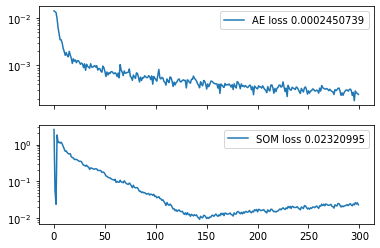

In [4]:
''' MAIN | OPTION: TRAIN
Train a DESOM-2 model.
'''

# -------- MODEL HYPERPARAMETERS --------
LATENT_DIMS = 100
map_size=(10,10) #SOM size
gamma=2e-4 # AE loss weight = 1, SOM loss weight = gamma
LR=6e-4

iterations = 15000
som_iterations = 10000
batch_size= 128
Tmax= 15
Tmin= 0.1

# --------- INITIALIZE MODEL --------
som = DESOM(input_dims= X_data.shape[1:], map_size = map_size, latent_dims=LATENT_DIMS)

optimizer = optimizers.Adam(LR)
som.initialize()
som.compile(gamma, optimizer)
som.init_som_weights(X_train)

# -------- (These are used to debug) ---------
Loss = list()
Lossr = list()
Losssom = list()
Losskm = list()
Losstop = list()
movingT = list()

# -------------- FIT MODEL -----------
start=time.time()
som.fit(X_train, iterations = iterations, som_iterations = som_iterations,
        batch_size= batch_size, Tmax= Tmax, Tmin= Tmin, decay='exponential')

# ------------ PRINT TRAINING PARAMETERS ----------
print('time:',time.time()-start)
print('gamma:',gamma)
print('lr',LR)
print('iterations',iterations)
print('som_iteration',som_iterations)
print('batch_size',batch_size)
print('T '+str(Tmax)+' '+str(Tmin))
print('latent width',LATENT_DIMS)

# ----------- PLOT LOSS FUNCTIONS -----------
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].semilogy(Lossr)
ax[0].legend([str('AE loss '+str(Lossr[-1]))])
ax[1].semilogy(Losssom)
ax[1].legend([str('SOM loss '+str(Losssom[-1]))])

In [7]:
''' OPTIONAL SAVE WEIGHTS
Save the weights of the above trained model. Best practice is to save SOM
size in name and AE architecture.
'''

MODEL_NAME='som2_jan18_test'

folder='SOM2_models/'
som.model.save_weights(folder+MODEL_NAME+'.h5')

In [16]:
''' MAIN | OPTION: LOAD PRETRAINED MODEL
Load a model from a previous training session.
'''

def load_desom_trained(map_size, input_dims, model_path, latent):
    # this defines the architecture of DESOM-2 before loading weights.
    inner_som = DESOM(input_dims= input_dims, map_size = map_size, latent_dims=latent)
    inner_som.initialize() #adds SOM layer to the model.
    inner_som.load_weights(model_path)
    return inner_som

MODEL_NAME='som2_jan18_test'
folder='SOM2_models/'

som = load_desom_trained((10,10), X_data.shape[1:], model_path=folder+MODEL_NAME+'.h5', latent=120)


In [5]:
''' MAIN
Calculate 'Best Matching Unit' for each galaxy
'''

# ------ Bin each fingerprint into the best node ------
best_node=som.predict(X_data)

# ------ Heightmap for where the galaxies end up -------
heightmap=np.zeros(map_size[0]*map_size[1])
for bmu in range(map_size[0]*map_size[1]):
    masked=(best_node==bmu)
    heightmap[bmu]=len(best_node[masked])


Text(0.5, 1.0, 'Distribution of 461 Test FPs into Prototypes')

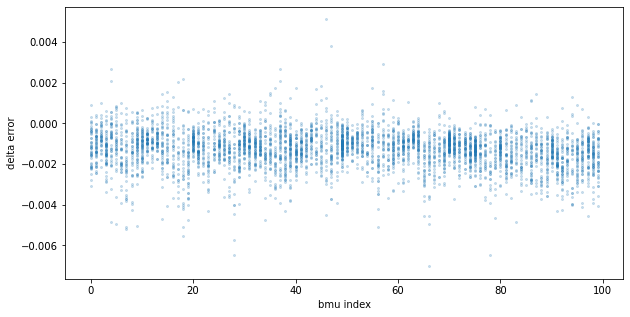

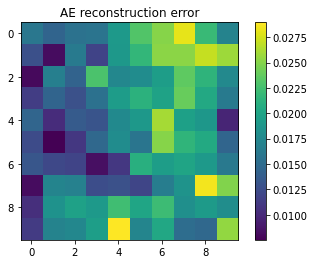

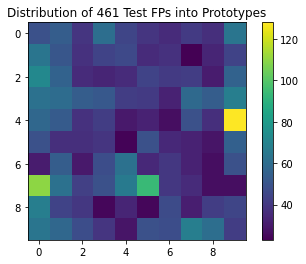

In [6]:
''' INSPECT
Plot residual reconstruction error and distribution of galaxies on SOM-2.
'''

map_size=som.map_size

# ------- CALCULATE RESIDUAL RECONSTRUCTION ERROR --------
recons=som.autoencoder.predict(X_data)
delta=recons-X_data

# --------- RESIDUAL ERROR BY BMU (1D) ----------
plt.figure(num=0,figsize=(10,5))
plt.scatter(best_node,np.average(delta.reshape(4609,SOM1_width**2),axis=1),s=4,alpha=0.2)
plt.ylabel('delta error')
plt.xlabel('bmu index')

# ---------- RESIDUAL ERROR BY BMU (2D) -----------
dumb_temp=np.zeros(map_size[0]*map_size[1])
for i in range(map_size[0]*map_size[1]):
    mask=(best_node==i)
    dumb_temp[i]=delta[mask].std()
    
plt.figure(1)
plt.imshow(dumb_temp.reshape(map_size))
plt.colorbar()
plt.title('AE reconstruction error')

# -------------- PLOT DISTRIBUTION OF GALAXIES ON SOM-2 -----------
cmap='viridis'
plt.figure(2)
plt.imshow(heightmap.reshape(map_size),cmap=cmap)
plt.colorbar()
plt.title('Distribution of 461 Test FPs into Prototypes')


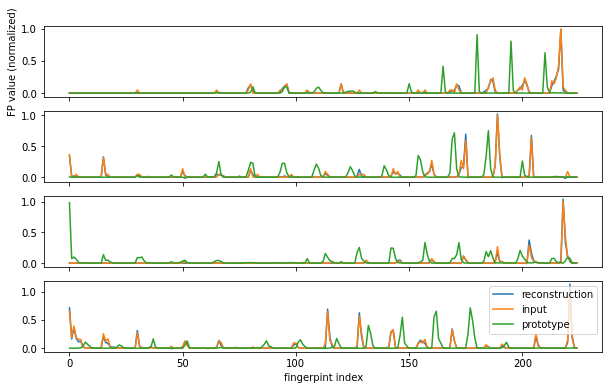

In [7]:
''' INSPECT
Look at input, reconstruction, and prototypes
'''

decoded_prototypes=som.decode(som.prototypes)

# -------- PREDICT FROM X_TEST ---------
ae,r=som.model.predict(X_test)

# ---------- PLOT INPUTS, RECONSTUCTIONS, PROTOTYPES'''
NUM_SAMPLES=4

fig,ax=plt.subplots(NUM_SAMPLES,1,figsize=(10,6),sharex=True)
for i in range(NUM_SAMPLES):
    ax[i].plot(ae[i].flatten())
    ax[i].plot(X_test[i].flatten())
    ax[i].plot(decoded_prototypes[int(best_node[i])].flatten())
ax[0].set_ylabel('FP value (normalized)')
ax[NUM_SAMPLES-1].set_xlabel('fingerpint index')
plt.legend(['reconstruction','input','prototype'])


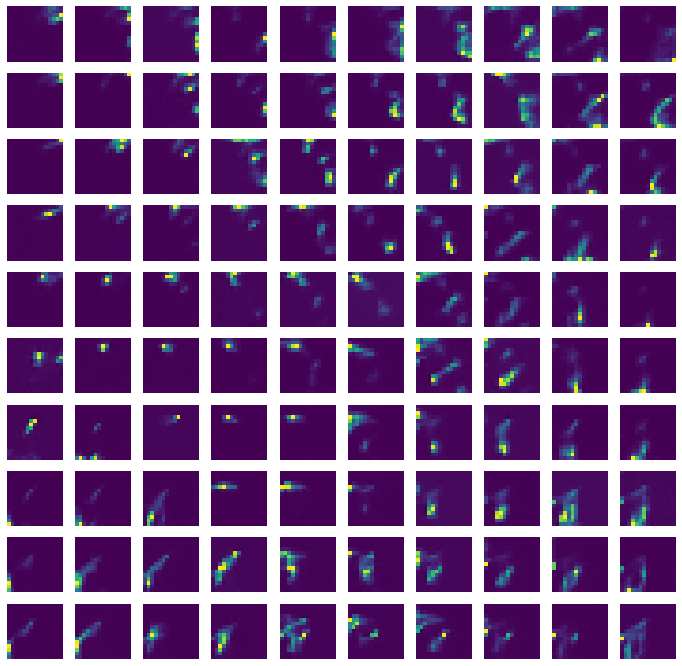

In [9]:
'''INSPECT
Visualize prototypes from DESOM-2 (prototypical galaxies)
'''

decoded_prototypes = som.decode(som.prototypes)

fig, ax = plt.subplots(map_size[0], map_size[1], figsize=(12,12))

# ----- SCALE HEIGHTMAP FOR OPTIONAL ALPHA -------
scaled_heightmap=MinMaxScaler().fit_transform((heightmap).reshape(-1,1)).reshape(-1)

for k in range(map_size[0]*map_size[1]):
    x = decoded_prototypes[k]
    ax[k // map_size[1]][k % map_size[1]].imshow(x.reshape(SOM1_width,SOM1_width),
                                                 #alpha=scaled_heightmap[k]
                                                 )
    ax[k // map_size[1]][k % map_size[1]].axis('off')
#plt.subplots_adjust(hspace=1.05, wspace=1.05)


In [10]:
''' MAIN
Make an array linking galaxy index to best node
'''

# ------ A list of each galaxy suffix in order ---------
gal_IDs=np.load('gal_unique_indexes.npy') # (4609,)

# ------ Merge -------
galID_bmu=np.array([gal_IDs,best_node]).T


In [11]:
''' MAIN
find average spectrum for each galaxy using their original data
'''

# ----- LOAD COADDED SPECTRA, ELSE GENERATE

try:
    coadded_spec=np.load('coadded_spectra.npy')
except:
    import concurrent.futures

    start=time.time()
    coadded_spec=np.zeros((4609,4544))
    print('generating coadded spectra!')

    # ------ Define Parallel Function ------
    def load_average(index):
        temp_spectral_data=np.load('data/gal_split_100/'+str(int(galID_bmu[index,0]))+'.npy')
        return np.average(temp_spectral_data,axis=0)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results=executor.map(load_average,np.arange(4609))
        
    # ------- Unravel 'results'
    for i,av_spec in enumerate(results):
        coadded_spec[i]=av_spec
    
    print(time.time()-start)
    np.save(coadded_spec,'coadded_spectra.npy')

# --------- Generate average Spectra in each node ------
averaged_origs=np.zeros((map_size[0]*map_size[1],4544))
for bmu in range(map_size[0]*map_size[1]): #for each node in SOM2
    mask=(galID_bmu[:,1]==int(bmu))
    averaged_origs[bmu]=np.average(coadded_spec[mask],axis=0)
        

Text(0.5, 0.98, 'Averaged spectra')

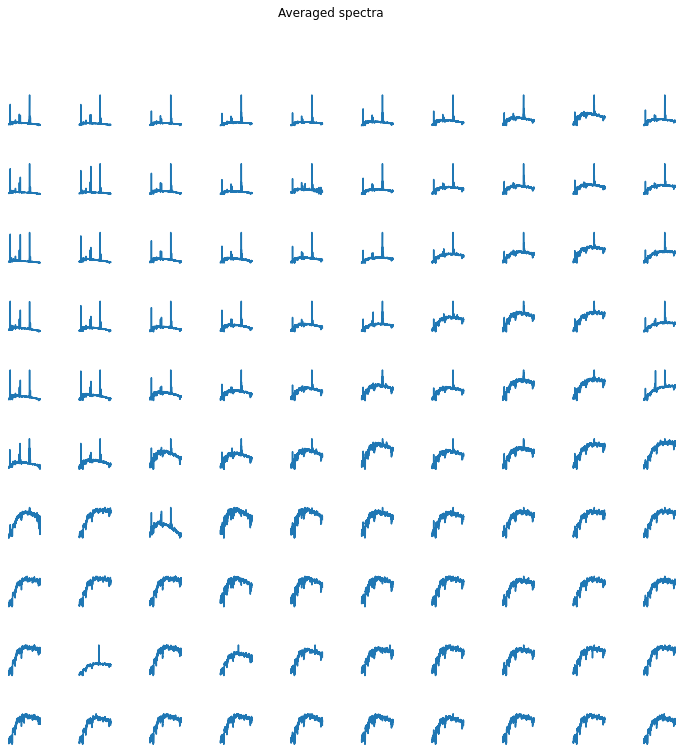

In [12]:
''' INSPECT
Visualize average spectra in node (galaxies were averaged before nodes being averaged)
'''

fig, ax = plt.subplots(map_size[0],map_size[1], figsize=(12,12))
for k in range(map_size[0]*map_size[1]):
    x = averaged_origs[k]
    ax[k // map_size[1]][k % map_size[1]].plot(x)
    ax[k // map_size[1]][k % map_size[1]].axis('off')
plt.subplots_adjust(hspace=1.05, wspace=1.05)
plt.suptitle('Averaged spectra')


Text(0.5, 0.98, 'node_index: 17. 23 galaxies')

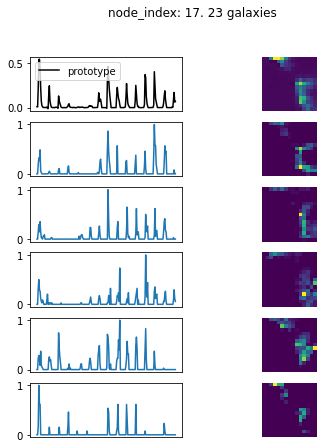

In [19]:
'''INSPECT
For a node, plot the prototype in 1D and 2D, and some number of samples.
'''

# ------ SELECT NODE TO INSPECT -------
NODE_INDEX=17
SAMPLES=5
SAMPLES=min(len(X_data[mask]),SAMPLES)
mask=(galID_bmu[:,1]==NODE_INDEX)

# -------- PLOT 1D and corresponding 2D --------
fig,ax=plt.subplots(SAMPLES+1,2, figsize=(6,7))

# ------- PLOT PROTOTYPE --------
ax[0][0].plot(decoded_prototypes[NODE_INDEX].flatten(),c='black')
ax[0][0].set_xticks([])
ax[0][0].legend(['prototype'])
ax[0][1].imshow(decoded_prototypes[NODE_INDEX].reshape(SOM1_width,SOM1_width))
ax[0][1].axis('off')

# ------- PLOT SAMPLES --------
for i in range(1,SAMPLES+1):
    ax[i][0].plot(X_data[mask][i].flatten())
    ax[i][0].set_xticks([])
for i in range(1,SAMPLES+1):
    ax[i][1].imshow(X_data[mask][i].reshape(SOM1_width,SOM1_width))
    ax[i][1].axis('off')

plt.suptitle(str('node_index: '+str(NODE_INDEX)+'. '+str(len(X_data[mask]))+' galaxies'))


Text(0.5, 0.98, 'node_index: 17. 23 galaxies')

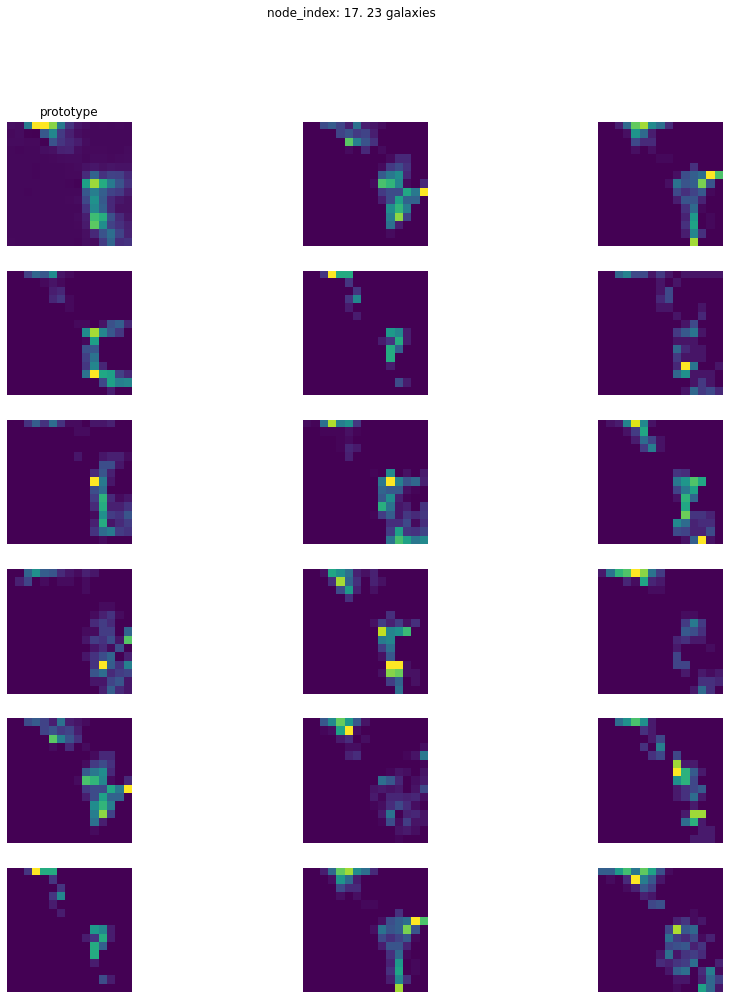

In [20]:
'''INSPECT
Look at more reconstructions in 2D. Not my best code.
'''

# ----- SELECT NODE TO INSPECT ------
NODE_INDEX=17
mask=(galID_bmu[:,1]==NODE_INDEX)
SAMPLES=5
SAMPLES=min(len(X_data[mask])*3,SAMPLES)

# -------- PLOT -------
fig,ax=plt.subplots(SAMPLES+1,3,sharex=True, sharey=True, figsize=(15,16))
# -------- PLOT PROTOTYPE (TOP LEFT) --------
ax[0,0].imshow(decoded_prototypes[NODE_INDEX].reshape(SOM1_width,SOM1_width))#,cmap='cool')
ax[0,0].set_title('prototype')
ax[0,0].axis('off')
# -------- PLOT SAMPLES --------
for i in range(1,SAMPLES+1):
    ax[i,0].imshow(X_data[mask][i].reshape(SOM1_width,SOM1_width))#,cmap='cool')
    ax[i,0].axis('off')
for i in range(0,SAMPLES+1):
    ax[i,1].imshow(X_data[mask][i+SAMPLES-1].reshape(SOM1_width,SOM1_width))#,cmap='cool')
    ax[i,1].axis('off')
for i in range(0,SAMPLES+1):
    ax[i,2].imshow(X_data[mask][i+SAMPLES*2-1].reshape(SOM1_width,SOM1_width))#,cmap='cool')
    ax[i,2].axis('off')

plt.suptitle(str('node_index: '+str(NODE_INDEX)+'. '+str(len(X_data[mask]))+' galaxies'))


In [21]:
'''MAIN
load attributes and generate additional attributes
'''

# ---------- LOAD MAIN DATA ----------
from astropy.io import fits
from astropy.table import Table, vstack

path='/project/rrg-jfncc/jwoo/astro/data/MANGA/manga/dr15/baxels/MLdata/'

full_info=Table.read(path+'datatab0.fits')
#print(full_info.colnames)
for i in range(1,10):
    full_info=vstack([full_info,Table.read(path+'datatab'+str(i)+'.fits')])

# --------- GENERATE ADDITIONAL ATTRIBUTES ---------
# ------- Pull out MaNGA_ID suffix
r=np.array(full_info['mangaID'],dtype='str')
r2=np.zeros(len(r),dtype='int')
for i in range(len(r)):
    r2[i]=int(r[i].split('-')[1])
full_info['suffix']=r2

# -------- Append BMU for the galaxy --------
full_info['bmu']=-1
for i in range(len(galID_bmu)):
    mask=(full_info['suffix']==galID_bmu[i,0])
    associated_node=galID_bmu[i,1]
    full_info['bmu'][mask]=associated_node
    
# -------- Adds sSFR and logMS_dens_kpc to info ------
from astropy.cosmology import FlatLambdaCDM
cosmod = FlatLambdaCDM(name='Concordance',H0=70.0,Om0=0.3,Tcmb0=2.725, Neff=3.04, Ob0=0.0463)
#
pixscale = 0.000138889*3600. # arcsec (seems to be same for all cubes)
pixscale = pixscale/3600.*np.pi/180. # radians
comd_bax = cosmod.comoving_distance(full_info['redshift']).value*1.0e3 #comoving dist in kpc
spaxsize_bax = pixscale*comd_bax/(1.0 + full_info['redshift']) # kpc
spaxsize_bax = spaxsize_bax**2. # kpc^2
#
logMs_dens_kpc = full_info['logMs_dens'] - np.log10(spaxsize_bax)  # solar mass per kpc^2
#
full_info['logMS_dens_kpc']=logMs_dens_kpc
full_info['sSFR']=full_info['logSFR_dens']-full_info['logMS_dens_kpc']

# ------- Take Log of ML_r --------
full_info['logML_r']=np.log(full_info['ML_r'])

/home/finnarch/jupyter_py3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


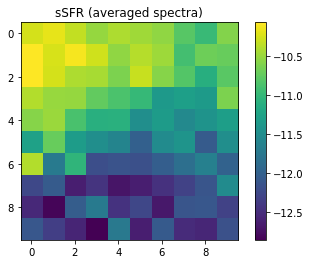

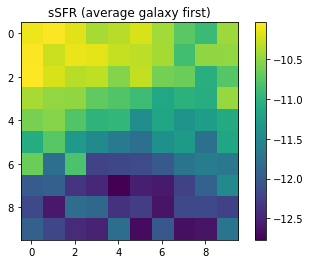

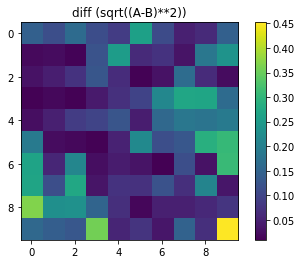

In [22]:
''' INSPECT
Shows there is only a small difference between taking average of all spectra
compared to taking the average within galaxies first.
'''

ATTR='sSFR'

# --------- PLOT AVERAGE OF ALL SPECTRA IN NODE ---------
temp_param=np.zeros(som.map_size[0]*som.map_size[1])
for i in range(som.map_size[0]*som.map_size[1]):
    mask=(full_info['bmu']==i)
    temp_param[i]=np.nanmedian(full_info[ATTR][mask])
plt.figure(0)
plt.imshow(temp_param.reshape(som.map_size))
plt.title(ATTR+' (averaged spectra)')
plt.colorbar()

# ----------- TAKE AVERAGE OF GALAXY, THEN AVERAGE THOSE ----------
temp_param2=np.zeros(som.map_size[0]*som.map_size[1])
for i in range(som.map_size[0]*som.map_size[1]):
    temp_list=list()
    mask_bmu=(full_info['bmu']==i)
    temp_list_of_gals=np.unique(full_info['suffix'][mask_bmu])
    for k in range(len(temp_list_of_gals)):
        mask_gal=(full_info['suffix']==temp_list_of_gals[k])
        temp_list.append(np.nanmedian(full_info[ATTR][mask_gal]))
    temp_param2[i]=np.nanmedian(temp_list)
plt.figure(1)
plt.imshow(temp_param2.reshape(som.map_size))
plt.title(ATTR+' (average galaxy first)')
plt.colorbar()

# --------- PLOT RMSE -----------
plt.figure(2)
plt.imshow((np.sqrt((temp_param2-temp_param)**2).reshape(som.map_size)))
plt.title('diff (sqrt((A-B)**2))')
plt.colorbar()

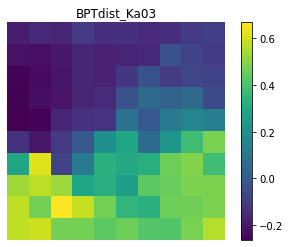

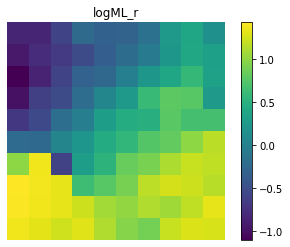

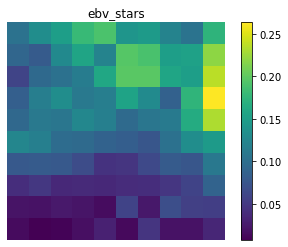

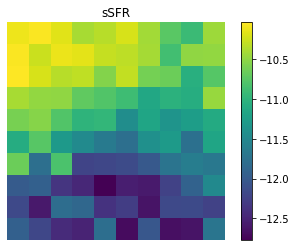

In [23]:
'''INSPECT
Plot several attributes (in separate figures). Averages are precomputed within the galaxy
'''

ATTR=['BPTdist_Ka03','logML_r','ebv_stars','sSFR']

for m in range(len(ATTR)):
    plt.figure(m)
    temp_param=np.zeros(map_size[0]*map_size[1])
    for i in range(map_size[0]*map_size[1]):
        temp_list=list()
        mask_bmu=(full_info['bmu']==i)
        temp_list_of_gals=np.unique(full_info['suffix'][mask_bmu])
        for k in range(len(temp_list_of_gals)):
            mask_gal=(full_info['suffix']==temp_list_of_gals[k])
            temp_list.append(np.nanmedian(full_info[ATTR[m]][mask_gal]))
        temp_param[i]=np.nanmedian(temp_list)
    plt.imshow(temp_param.reshape(map_size))
    plt.title(ATTR[m])
    plt.axis('off')
    plt.colorbar()
    

mask: -8 Max


/home/finnarch/jupyter_py3/lib/python3.6/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/home/finnarch/jupyter_py3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/finnarch/jupyter_py3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'all counts')

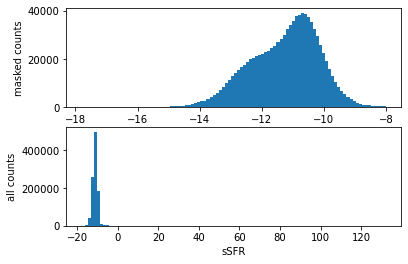

In [24]:
'''INSPECT
Plot the distribution of a paramter from the whole dataset.
Mask selection as needed.
'''

# ------ DEFINE ATTRIBUTE AND MASKING ----------
ATTR='sSFR'
MIN=None
MAX=-8

# --------- MAKE MASK --------
min_mask=np.ones(len(full_info),dtype=bool)
max_mask=np.ones(len(full_info),dtype=bool)
if MIN != None:
    print('mask:',MIN,'Min')
    min_mask=(full_info[ATTR]>MIN)
if MAX != None:
    print('mask:',MAX,'Max')
    max_mask=(full_info[ATTR]<MAX)
mask=min_mask*max_mask

# --------- PLOT
fig,ax=plt.subplots(2,1)
ax[0].hist(full_info[ATTR][mask],bins=100)
ax[1].hist(full_info[ATTR],bins=100)

ax[1].set_xlabel(ATTR)
ax[0].set_ylabel('masked counts')
ax[1].set_ylabel('all counts')


In [25]:
'''INSPECT
pull galaxy IDs from a node
'''

# ------- SELECT NODE -------
NODE_ID=17

# ------- PULL OUT BOTH MaNGA_ID and SUFFIX ---------
def galaxies_in_node(index):
    mask=(full_info['bmu']==index)
    manga_col=full_info['mangaID'][mask]
    suffix_col=full_info['suffix'][mask]
    manga_col=np.unique(manga_col)
    suffix_col=np.unique(suffix_col)
    z_manga,z_suffix=list(),list()
    for i in range(len(manga_col)):
        z_manga.append(manga_col[i])
        z_suffix.append(suffix_col[i])
    return z_manga,z_suffix

manga_ids,suffix_ids=galaxies_in_node(NODE_ID)

# ----- PRINT FIVE ------
print(manga_ids[:5])

['1-135030', '1-149536', '1-155463', '1-155975', '1-172986']


In [26]:
''' INSPECT
find where a specific galaxy falls on the SOM'''

TARGET_GALAXY = '44219' # use suffix

# ------ 'galID_bmu' METHOD --------
z=np.where(galID_bmu[:,0]==int(TARGET_GALAXY))[0]
print('BMU:',galID_bmu[z,1],'\n')

# --------- 'full_info' METHOD ---------
if '-' in TARGET_GALAXY:
    mask=(full_info['mangaID']==TARGET_GALAXY)
else:
    mask=(full_info['suffix']==int(TARGET_GALAXY))
    
print('BMU:',full_info['bmu'][mask][0])

BMU: [27.] 

BMU: 27
